In [ ]:
# coding=utf-8
#
# The copyright of this file belongs to Feedzai. The file cannot be
# reproduced in whole or in part, stored in a retrieval system,
# transmitted in any form, or by any means electronic, mechanical,
# photocopying, or otherwise, without the prior permission of the owner.
#
# (c) 2022 Feedzai, Strictly Confidential

In [7]:
from typing import *

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (5,3.5)

# Figure 1 in the paper

In [12]:
def scatter_oneBias_nAlgos_nSeeds(
    df: pd.DataFrame,
    p_metric: str, # performance metric
    f_metric: str, # fairness metric
    algos: List[str] = ["XGB", "LGBM", "LR", "DT", "RF", "MLP"], # choose which algorithms to plot
    min_max: bool = False,
    bias: str = "",
    threshold: float = 0.05,
    colors: List[str] = ["r", "b", "g", "y", "grey", "purple"],
    alpha: int = 1,
    s: int = 6,
    xlim: List[float] = [0.4, 1],
    xticks: List[float] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    yticks: List[float] = [-3, -2, -1, 0, 1, 2, 3],
    ncol: int = 6,
    ymin: float = -3,
    ymax: float = 3,
    fig = "",
    ax = "" # ax if one wants to do panel plots
    ):
    """
    """
    if not ax:
        fig, ax = plt.subplots()
        plt.hlines(y=[np.log2(1.25), np.log2(0.8)], xmin=0, xmax=1, colors="r", linestyles="dashed", alpha=0.5)
    # Log scale or not
    if min_max:
        ax.set(ylim=(0, 1.02))
    else:
        ax.set(ylim=(ymin, ymax))

    # Scatter plot; see readme for info.
    sns.scatterplot(
        ax=ax,
        data=df[df["algorithm"].isin(algos)].sample(frac=1), # shuffle df so that some points are not hidden systematically
        x=p_metric,
        y=f_metric,
        hue='algorithm',
        hue_order=algos,
        alpha=alpha,
        palette=colors[:len(algos)],
        s=s,
        legend=False
    )

    # Axes aesthetics
    ax.set(
        xlabel=make_xlabel(p_metric),
        ylabel=make_ylabel(f_metric, min_max),
        xlim=xlim,
        xticks=xticks,
        yticks=yticks
    )
    sns.despine(fig)
    #plt.show()

def make_ylabel(
    f: str,
    min_max: bool
) -> str:
    """
    """
    if min_max:
        log_str = ""
        mm_str = " (min/max)"
    else:
        log_str = " (log2)"
        mm_str = " (A/B)"
    if "ratio" in f:
        f_str = fr"$\bf{f[:-6].upper()}$"

    out_str = f"Groupwise {f_str} Ratio{mm_str}{log_str}"
    return out_str


def make_xlabel(
    p: str
    ) -> str:
    """
    """
    if p == "recall":
        p_str = "Global TPR"

    out_str = f"{p_str}"

    return out_str

In [13]:
df = pd.read_csv("../results_data/figure_1.csv")

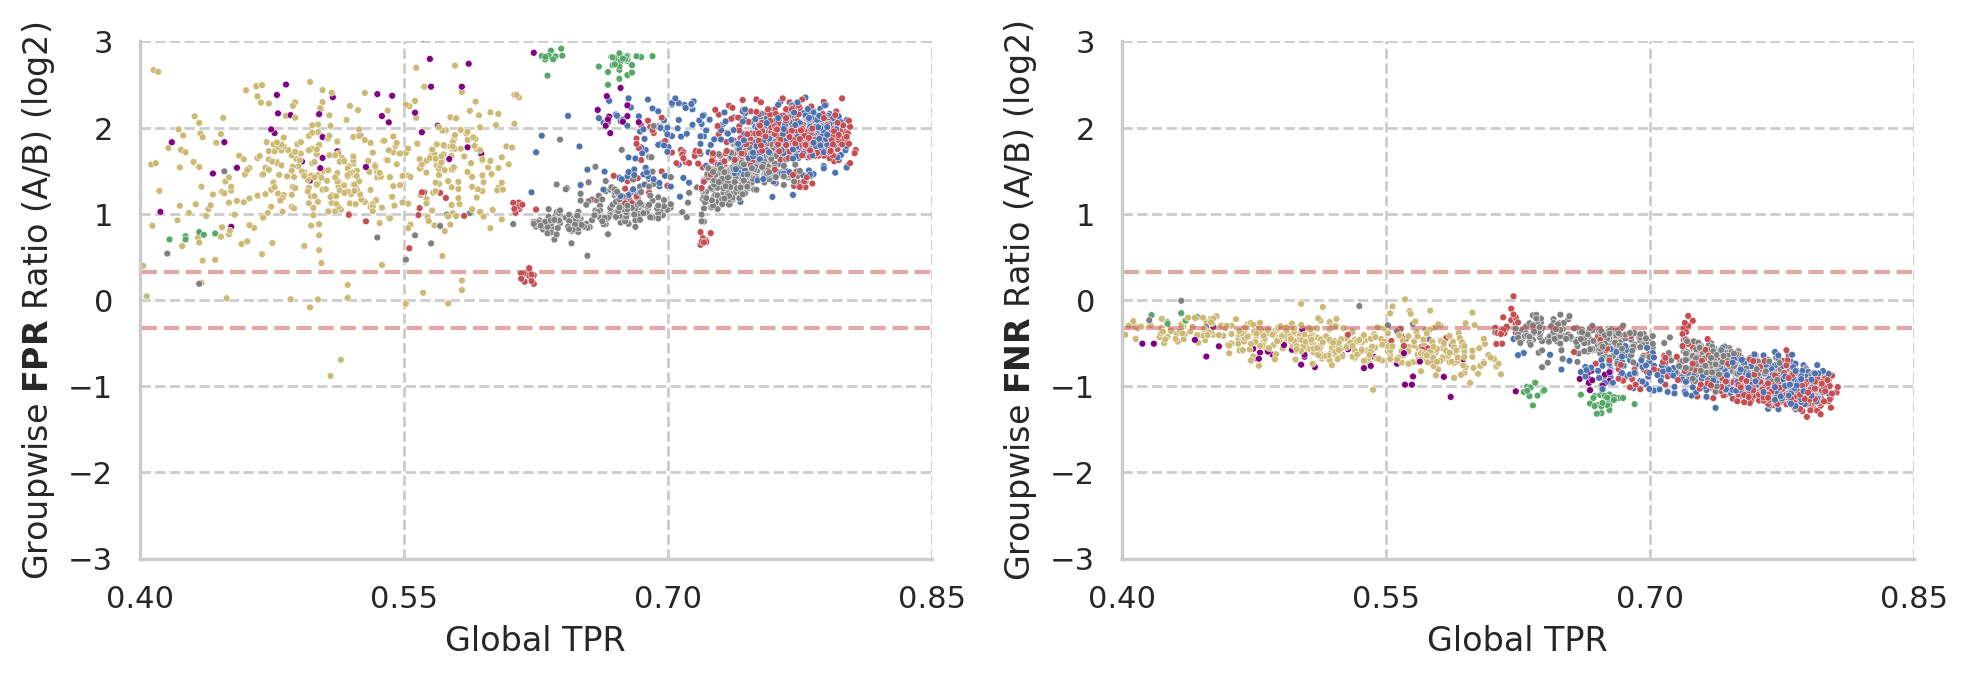

In [14]:
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (10,3.5) # adjust width and height to panel needs

fig, (ax1, ax2) = plt.subplots(1, 2)

for ax, metric in zip([ax1, ax2], ["fpr_ratio", "fnr_ratio"]):
    scatter_oneBias_nAlgos_nSeeds(df=df, 
                                  p_metric="recall", f_metric=metric,
                                  xlim=[0.4, 0.85],
                                  xticks=np.arange(0.4, 1, 0.15),
                                  fig=fig, ax=ax
                                  )

    ax.hlines(y=[np.log2(1.25), np.log2(0.8)], xmin=0, xmax=1, colors="r", linestyles="dashed", alpha=0.5)
    
plt.tight_layout()
plt.show()

# Figure 4 in the paper

In [15]:
def min_median_max_oneBias_nAlgos(
    df: pd.DataFrame,
    p_metric: str, # performance metric
    f_metric: str, # fairness metric
    min_max: bool = False,
    center_method: str = "median",
    bias: str = "",
    threshold: float = 0.05,
    algos: List[str] = ["XGB", "LGBM", "LR", "DT", "RF", "MLP"],
    colors: List[str] = ["r", "b", "g", "y", "grey", "purple"],
    alpha: int = 1,
    s: int = 6,
    capsize: float = 2.5,
    capthick: float = 1,
    elinewidth: float = 1,
    xlim: List[float] = [0.5, 1],
    xticks: List[float] = [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    yticks: List[float] = [-3, -2, -1, 0, 1, 2, 3],
    ncol: int = 6,
    ymin: float = -3,
    ymax: float = 3,
    fig = "",
    ax = "" # ax if one wants to do panel plots
    ):
    """
    """
    if not ax:
        fig, ax = plt.subplots()
        plt.hlines(y=[np.log2(1.25), np.log2(0.8)], xmin=0, xmax=1, colors="r", linestyles="dashed", alpha=0.5)
    if min_max:
        ax.set(ylim=(0, 1.02))
    else:
        ax.set(ylim=(ymin, ymax))

    # Group observations by config and algorithm. Now, each algo will have 10 points, the best performing config for each seed
    # First sort by recall, then drop duplicates of algorithm seed combinations.
    # This gets us the best performing algorithm-seed combo for each algorithm and seed (6*10 points in total) 
    plot_df = df.sort_values(by='recall', ascending=False).drop_duplicates(["algorithm","seed"])

    for c, a in zip(colors, algos):
       
        # Get centers of crosses (median of each dimension)
        x_center, y_center = get_centers(center_method=center_method, df=plot_df[plot_df["algorithm"] == a],
                                         p_metric=p_metric, f_metric=f_metric)
        
        # Get edges of crosses. Respectively: min fairness, max fairness, min performance, max performance
        y_err_dn, y_err_up, x_err_dn, x_err_up = get_errors(plot_df[plot_df["algorithm"] == a], 
                                                 x_center=x_center, y_center=y_center,
                                                 p_metric=p_metric, f_metric=f_metric)

        # Plot bars and edges
        ax.errorbar(x_center, y_center, [[y_err_dn], [y_err_up]], [[x_err_dn], [x_err_up]], 
                    ls="None", capsize=capsize, capthick=capthick, ecolor=c, elinewidth=elinewidth, color=c, label=a)
        # Plot center of crosses
        ax.scatter(x_center, y_center, color=c, s=s, alpha=alpha)

        # Axes aesthetics
    ax.set(
        xlabel=make_xlabel(p_metric), 
        ylabel=make_ylabel(f_metric, min_max),
        xlim=xlim,
        xticks=xticks,
        yticks=yticks
    )
    sns.despine(fig)

def get_centers(
    center_method: str,
    df: pd.DataFrame,
    p_metric: str,
    f_metric: str
) -> Tuple[float]:
    """
    """
    if center_method == "mean":
        x_center = df[f"{p_metric}"].mean()
        y_center = df[f"{f_metric}"].mean()
    elif center_method == "median":
        x_center = df[f"{p_metric}"].median()
        y_center = df[f"{f_metric}"].median()
    return x_center, y_center
    

def get_errors(
    df: pd.DataFrame,
    x_center,
    y_center,
    p_metric: str,
    f_metric: str
) -> Tuple[float]:
    """
    Errors as in min max of each metric (performance and fairness)
    """
    x_err_dn = x_center - df[f"{p_metric}"].min()
    y_err_dn = y_center - df[f"{f_metric}"].min()
    x_err_up = df[f"{p_metric}"].max() - x_center
    y_err_up = df[f"{f_metric}"].max() - y_center

        
    return y_err_dn, y_err_up, x_err_dn, x_err_up

In [33]:
dfs = []
for group_size in ["50", "90", "99"]:
    df = pd.read_csv(f"../results_data/figure_4_{group_size}.csv")
    dfs.append(df) # see readme for info on what the df contains.

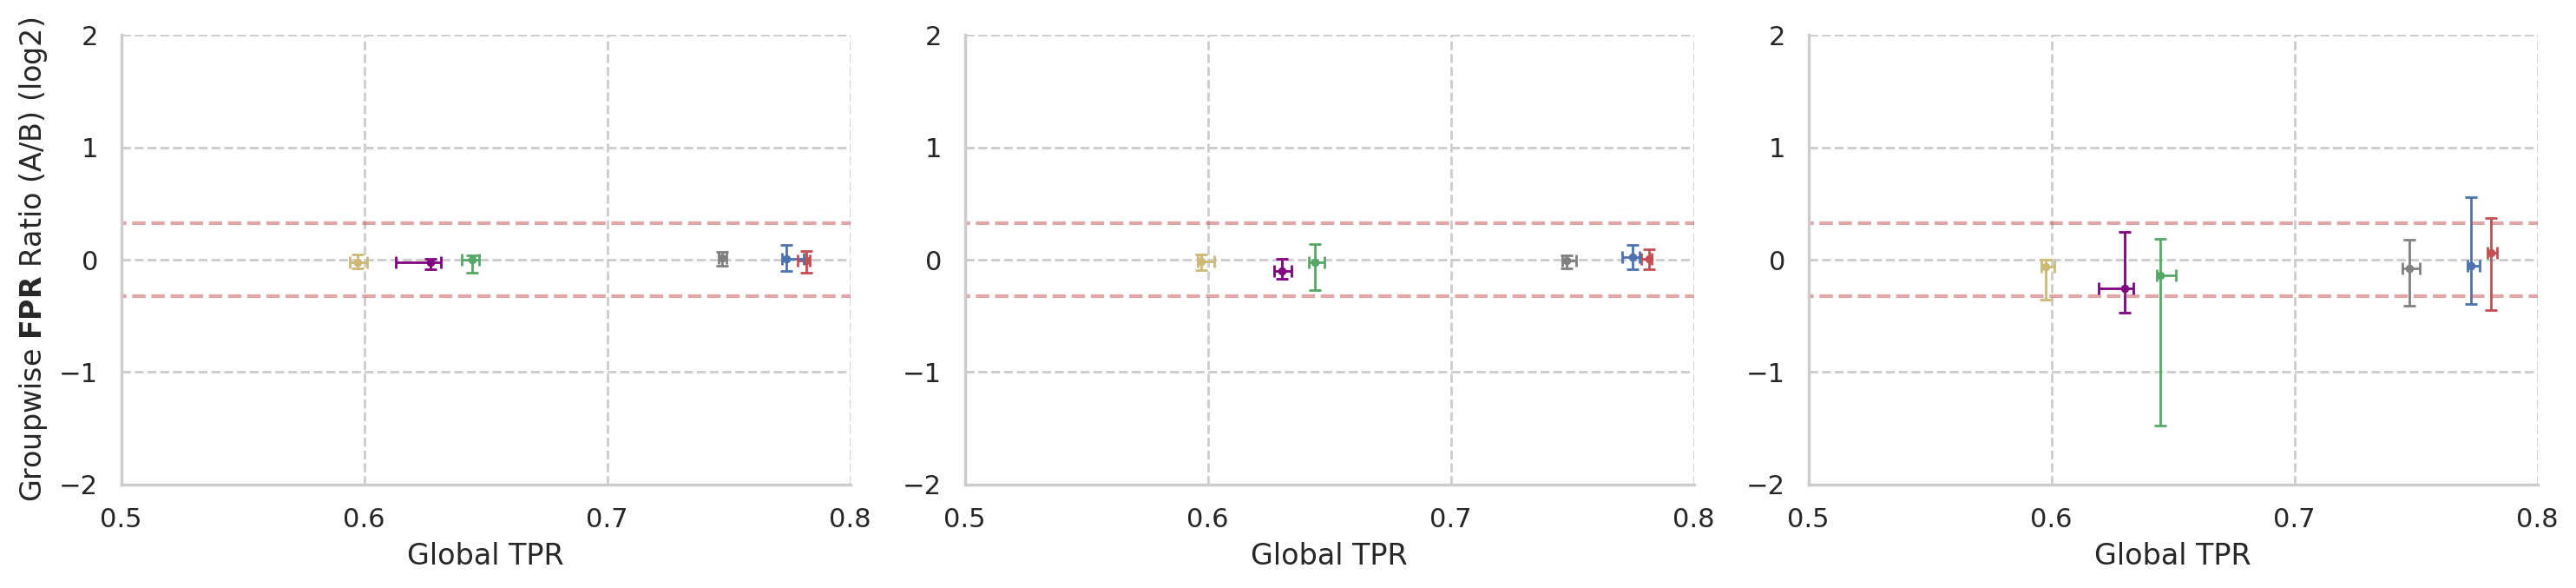

In [35]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3)

for ax, df in zip([ax1, ax2, ax3], dfs):
    min_median_max_oneBias_nAlgos(df=df, 
                                  p_metric="recall", f_metric="fpr_ratio",
                                  xlim=[0.5, 0.8], ymin=-2, ymax=2,
                                  xticks=np.arange(0.5, 0.9, 0.1),
                                  yticks=np.arange(-2, 3, 1),
                                  fig=fig, ax=ax
                                  )

    ax.hlines(y=[np.log2(1.25), np.log2(0.8)], xmin=0, xmax=1, colors="r", linestyles="dashed", alpha=0.5)

    if ax != ax1:
        ax.yaxis.label.set_visible(False)

plt.rcParams['figure.figsize'] = (15,3.5)
plt.tight_layout()
plt.show()

# Figure 5 in the paper

In [24]:
def min_median_max_allBias_oneAlgo(
    dfs: List[pd.DataFrame],
    algo: str, # Contrary to other plots, this one is for one algorithm only,
    hypotheses: List[str],
    p_metric: str, # performance metric
    f_metric: str, # fairness metric
    min_max: bool = False,
    center_method: str = "median",
    bias: str = "",
    threshold: float = 0.05,
    colors: List[str] = ["cyan", "steelblue", "gold", "lightgreen", "darkgreen", "grey", "red", "darkred"],
    alpha: int = 1,
    s: int = 6,
    capsize: float = 2.5,
    capthick: float = 1,
    elinewidth: float = 1,
    xlim: List[float] = [0.55, 1],
    xticks: List[float] = [0.6, 0.7, 0.8, 0.9, 1],
    yticks: List[float] = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5],
    ncol: int = 6,
    ymin: float = -1.5,
    ymax: float = 1.5,
    legend: bool = False,
    title: str = "",
    fig = "",
    ax = "" # ax if one wants to do panel plots
    ):
    """
    """

    # Instantiate plot and initial aesthetic configuration
    if not ax:
        fig, ax = plt.subplots()
        plt.hlines(y=[np.log2(1.25), np.log2(0.8)], xmin=0, xmax=1, colors="r", linestyles="dashed", alpha=0.5)
    if min_max:
        ax.set(ylim=(0, 1.02))
    else:
        ax.set(ylim=(ymin, ymax))
        
    # Make plots
    # Logic is slightly different from the previous plot, since we have to use several dataframes (each one corresponds to a hypothesis)
    for c, df, h in zip(colors, dfs, hypotheses):
        # Sort and drop duplicates inside loop, since algorithm is always the same.
        plot_df = df[df["algorithm"] == algo].sort_values(by='recall', ascending=False).drop_duplicates(["algorithm","seed"])

        # Get centers of crosses (median of each dimension)
        x_center, y_center = get_centers(center_method=center_method, df=plot_df,
                                         p_metric=p_metric, f_metric=f_metric)

        # Get edges of crosses. Respectively: min fairness, max fairness, min performance, max performance
        y_err_dn, y_err_up, x_err_dn, x_err_up = get_errors(plot_df, 
                                                 x_center=x_center, y_center=y_center,
                                                 p_metric=p_metric, f_metric=f_metric)

        # Plot bars and edges
        ax.errorbar(x_center, y_center, [[y_err_dn], [y_err_up]], [[x_err_dn], [x_err_up]], 
                    ls="None", capsize=capsize, capthick=capthick, ecolor=c, elinewidth=elinewidth, color=c, label=h)
        # Plot center of bars
        ax.scatter(x_center, y_center, color=c, s=s, alpha=alpha)

    # Axes aesthetics
    ax.set(
        xlabel=make_xlabel(p_metric), 
        ylabel=make_ylabel(f_metric, min_max),
        xlim=xlim,
        xticks=xticks,
        yticks=yticks
    )
    if legend:
        ax.legend(loc='upper center', title="Hypothesis", ncol=ncol)
    if title:
        ax.set_title(title)
    sns.despine(fig)

In [31]:
dfs = []
for i in range(5):
    df = pd.read_csv(f"../results_data/figure_5_{i}.csv")
    dfs.append(df) # see readme for info on what the df contains.

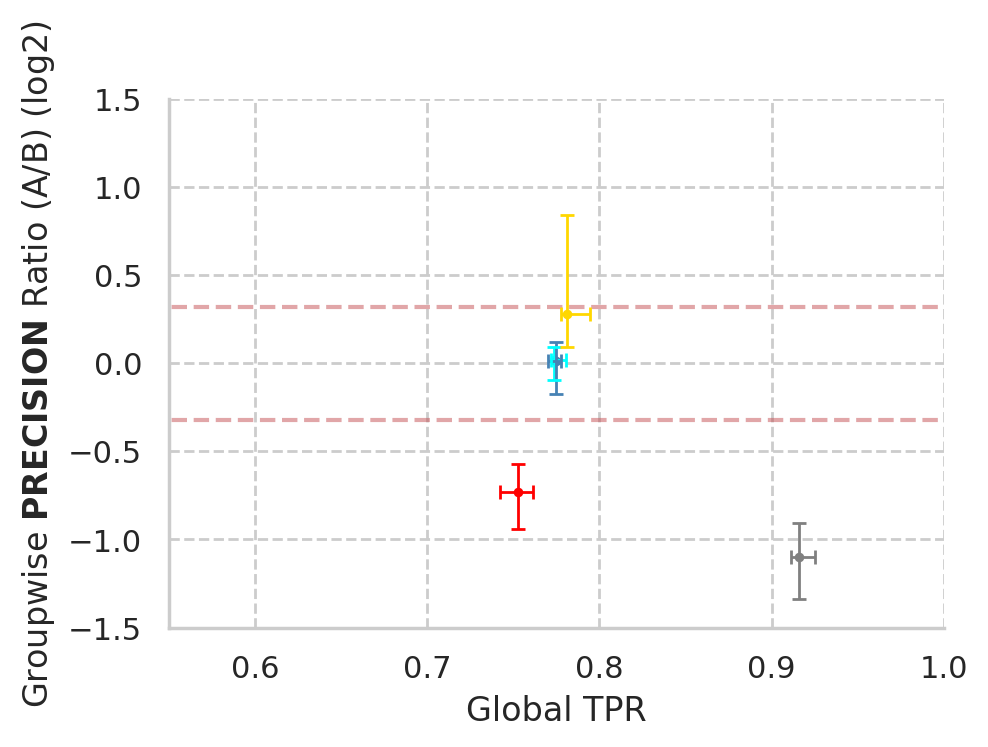

In [32]:
plt.rcParams['figure.figsize'] = (5,3.5)
min_median_max_allBias_oneAlgo(dfs=dfs, algo="LGBM", hypotheses=["H1", "H1", "H2.1", "H3", "H4.1"], p_metric="recall", f_metric="precision_ratio", colors=["cyan", "steelblue", "gold", "grey", "red"])

# Figure 6 in the paper

In [36]:
hypotheses = ["Baseline", "H1", "H2.1", "H2.2 (train)", "H2.2 (test)", "H3", "H4.1", "H4.2"]
dfs = []
for i in range(8):
    df = pd.read_csv(f"../results_data/figure_6_{i}.csv")
    dfs.append(df) # see readme for info on what the df contains.

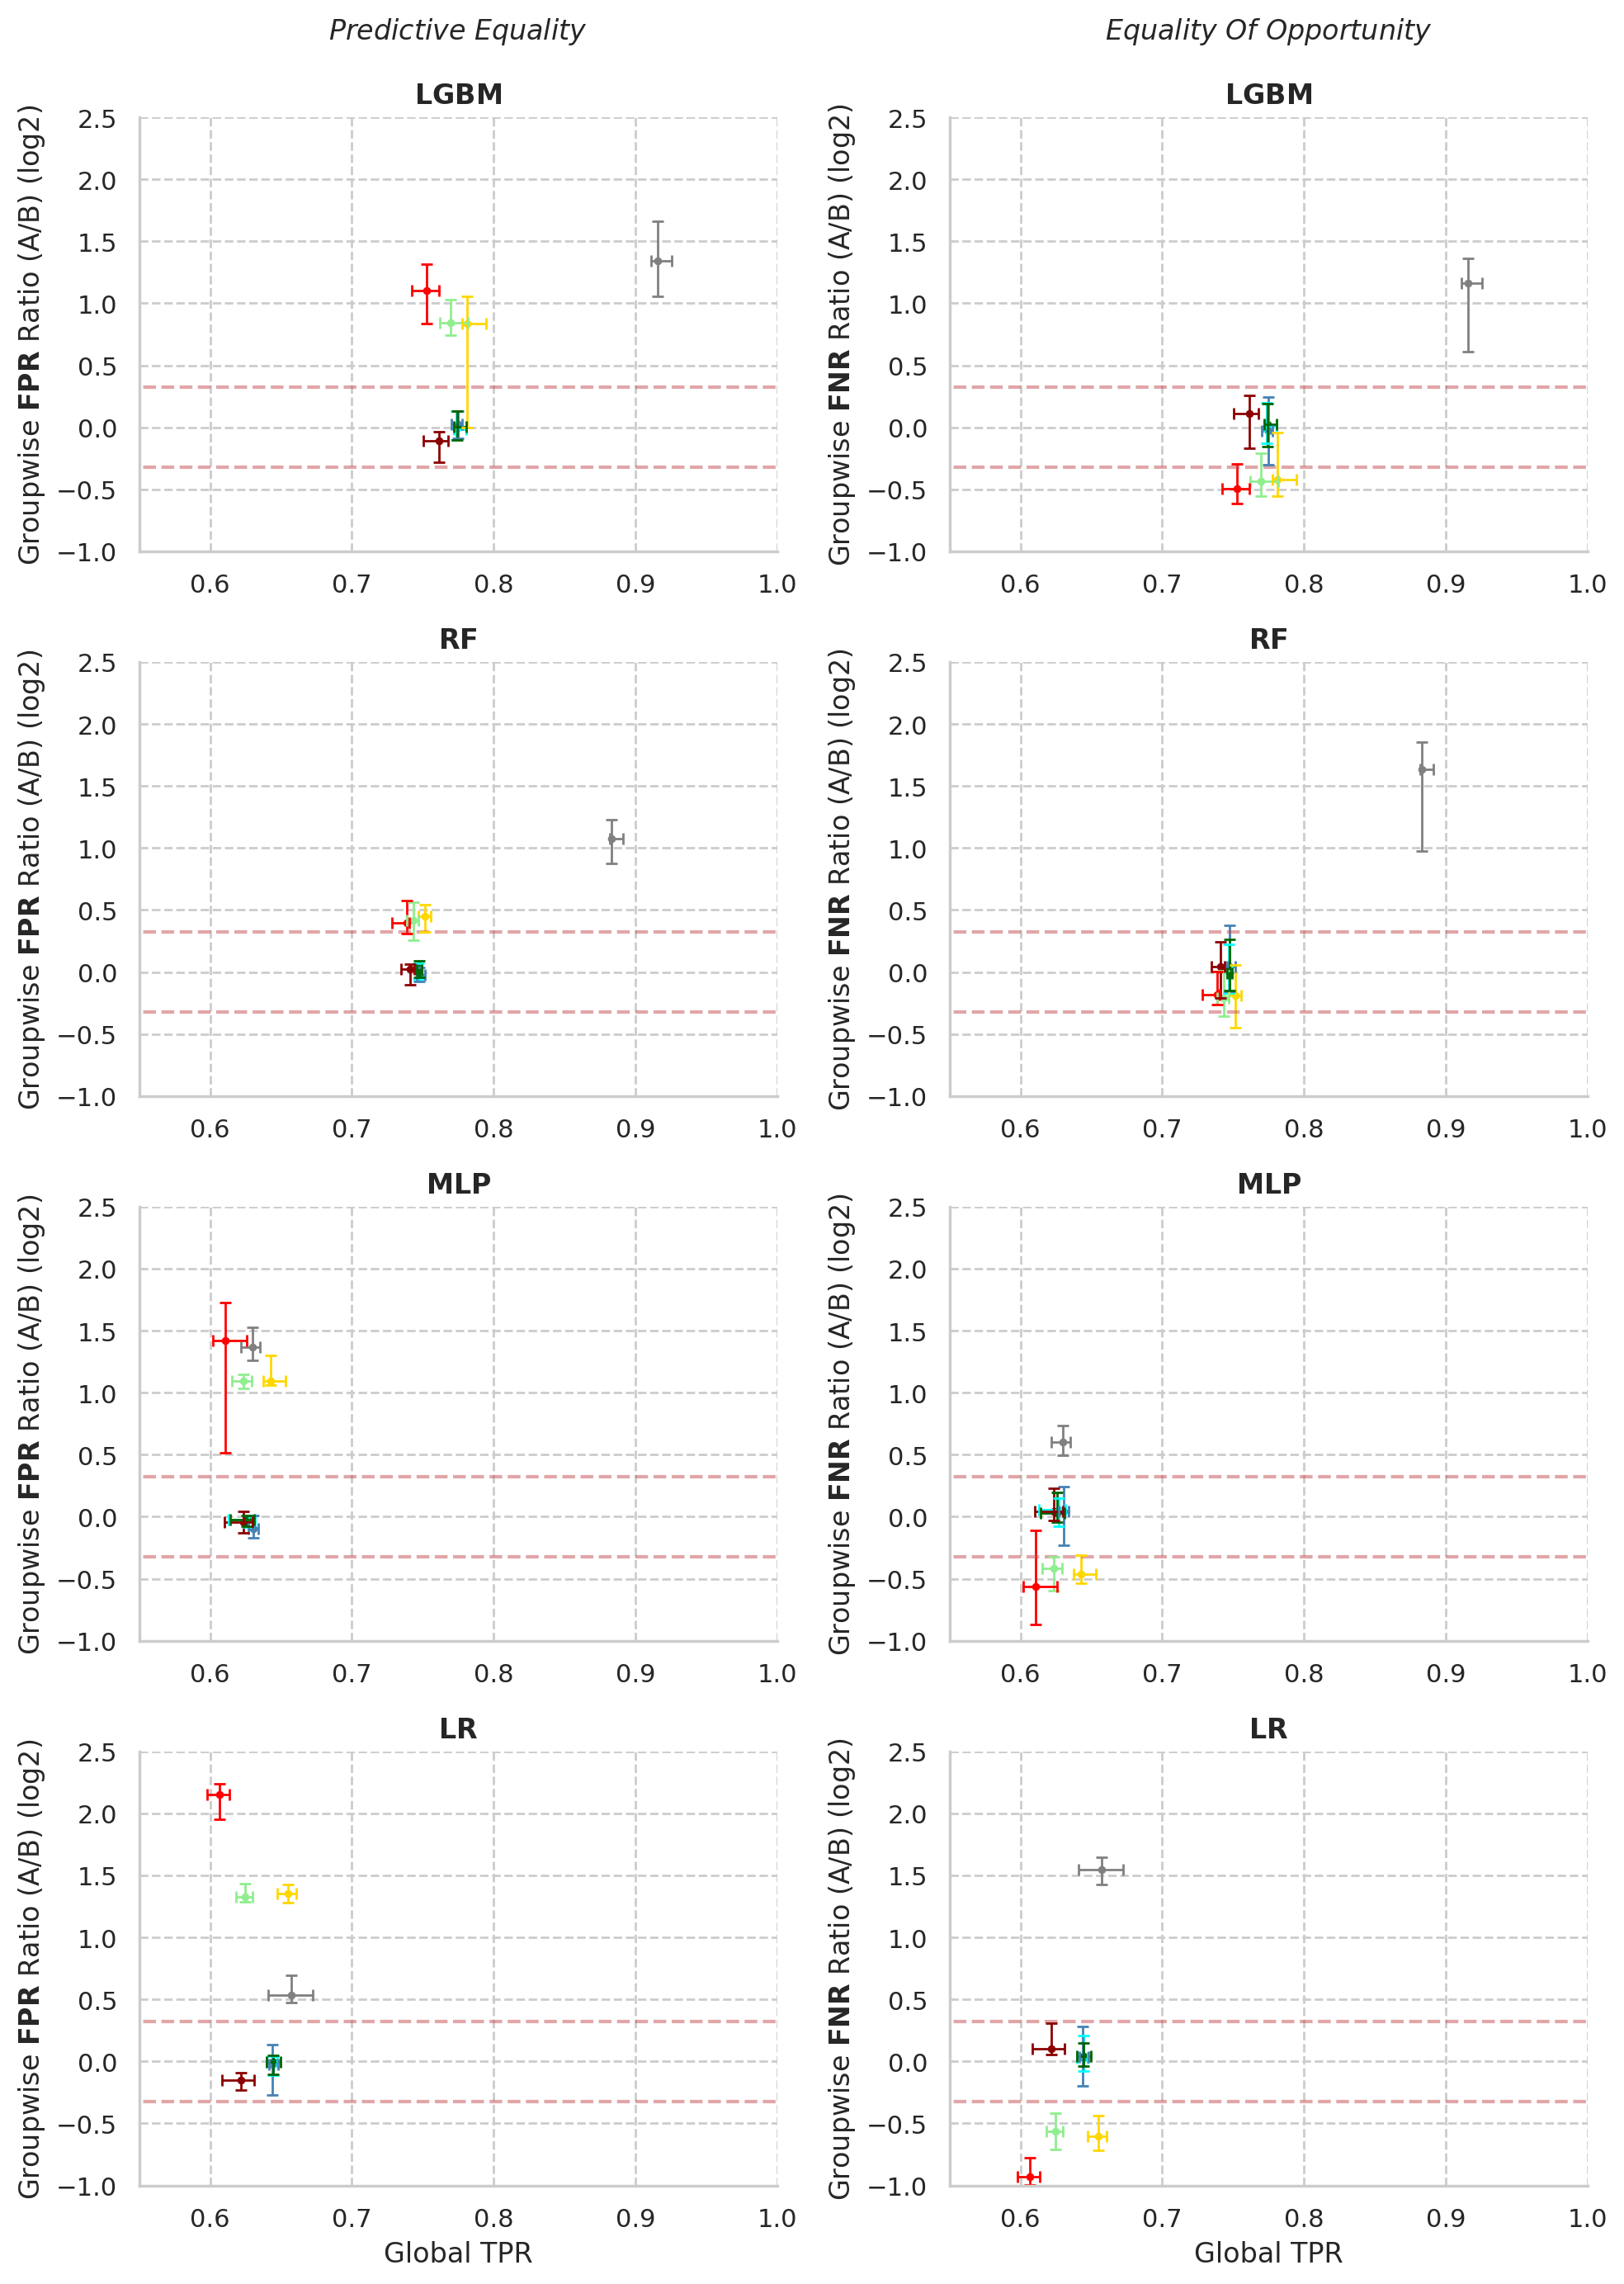

In [37]:
plt.rcParams['figure.figsize'] = (10, 14)

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8]] = plt.subplots(4, 2)

for ax, algo, metric in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], ["LGBM", "LGBM", "RF", "RF", "MLP", "MLP", "LR", "LR"], ["fpr_ratio", "fnr_ratio"] * 4):
    if metric == "fpr_ratio":
        m_str = r"$\it{Predictive}$" + " " + r"$\it{Equality}$"
    else:
        m_str = r"$\it{Equality}$" + " " + r"$\it{Of}$" + " "  + r"$\it{Opportunity}$"
    if algo == "LGBM":
        title = m_str + "\n\n" + r"$\bf{LGBM}$"
    else:
        title = fr"$\bf{algo}$"
    
    min_median_max_allBias_oneAlgo(dfs=dfs, 
                                   algo=algo,
                                   hypotheses=hypotheses,
                                   p_metric="recall", f_metric=metric,
                                   xlim=[0.55, 1], ymin=-1, ymax=2.5,
                                   xticks=np.arange(0.6, 1.01, 0.1),
                                   yticks=np.arange(-1, 3, .5),
                                   title=title,
                                   fig=fig, ax=ax
                                   )

    ax.hlines(y=[np.log2(1.25), np.log2(0.8)], xmin=0, xmax=1, colors="r", linestyles="dashed", alpha=0.5)

    if ax not in [ax7, ax8]:
        ax.xaxis.label.set_visible(False)

plt.tight_layout()
plt.show()
# Then save to pdf

# Scenario 5

## Figure 7 in the paper

In [5]:
df = pd.read_csv("../results_data/scenario_5.csv")

perf_metric = "recall"
fair_metric = "fpr_ratio"

top_configs = (
    df.loc[df["Scenario"] == "Performance Ideal"]
      .sort_values(by=perf_metric, ascending=False)
      .head(5)
      .loc[:, "config"]
      .values
)

best_df = df.drop(df.loc[~df["config"].isin(top_configs)].index)
worst_df = df.drop(df.loc[df["config"].isin(top_configs)].index)

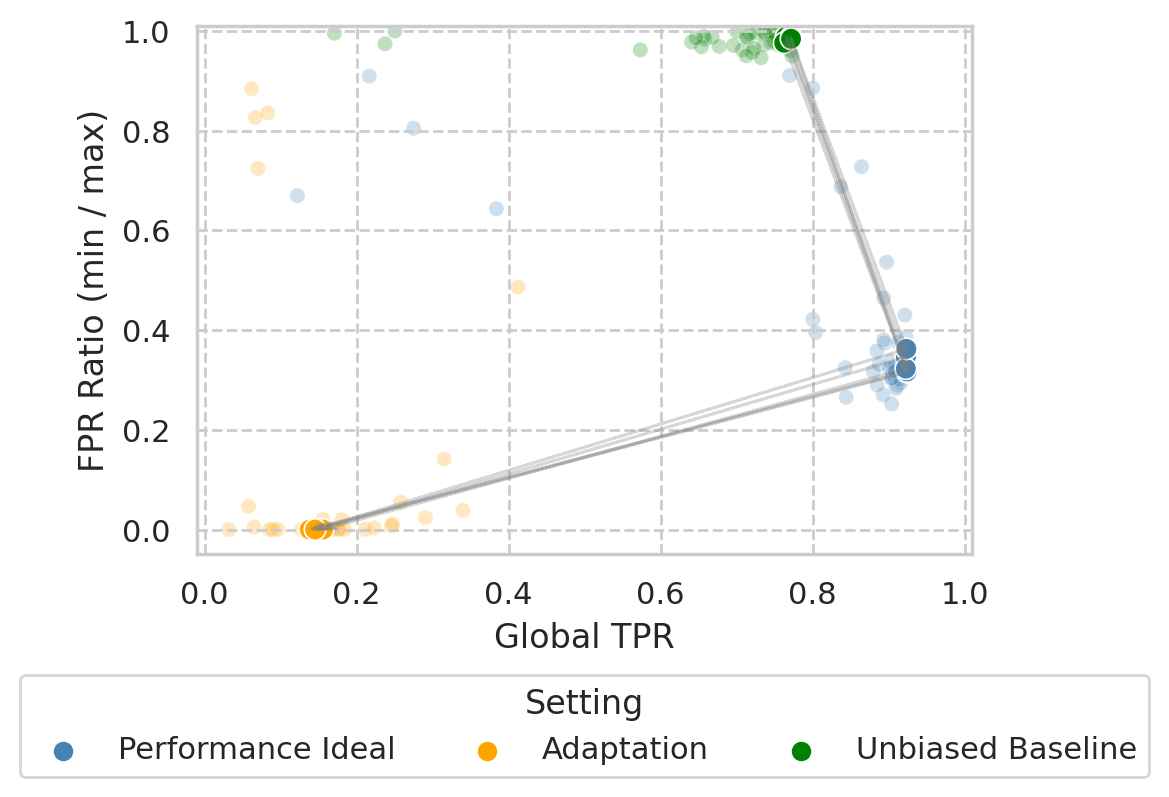

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(
    ax=ax,
    data=best_df,
    x="recall", y="fpr_ratio",
    hue="Scenario",
    palette=["green", "steelblue", "orange"],
    s=60
)

sns.scatterplot(
    ax=ax,
    data=worst_df,
    x="recall", y="fpr_ratio",
    hue="Scenario",
    palette=["green", "steelblue", "orange"],
    alpha=0.25,
    s=30,
    legend=False,
    zorder=-1
)

#ax.hlines(y=[0.8], xmin=-0.01, xmax=1.01, colors="r", linestyles="dashed", alpha=0.5)
# Axes aesthetics
ax.set(
    xlabel="Global TPR", 
    ylabel="FPR Ratio (min / max)",
    xlim=(-0.01, 1.01),
    ylim=(-0.05, 1.01),
    xticks=np.arange(0, 1.2, step=0.2),
    yticks=np.arange(0, 1.2, step=0.2)
)

# Draw arrows from each LightGBM to each corresponding FairGBM
unbiased = best_df[best_df["Scenario"] == "Unbiased Baseline"]#.reset_index(level=0)
performance = best_df[best_df["Scenario"] == "Performance Ideal"]#.reset_index(level=0)
adaptation = best_df[best_df["Scenario"] == "Adaptation"]#.reset_index(level=0)
#assert len(fairgbm_results) == len(lightgbm_results)

change_vectors = []
for pair in [[unbiased, performance], [performance, adaptation]]:
    for idx, row in pair[0].iterrows():
        model_id = row["config"]

        pair_0_row = pair[0][pair[0]["config"] == model_id]
        pair_1_row = pair[1][pair[1]["config"] == model_id]

        assert len(pair_0_row) == len(pair_1_row) == 1
        pair_0_row = pair_0_row.iloc[0]
        pair_1_row = pair_1_row.iloc[0]

        pair_0_x, pair_0_y = pair_0_row[perf_metric], pair_0_row[fair_metric]
        pair_1_x, pair_1_y = pair_1_row[perf_metric], pair_1_row[fair_metric]

        change_vectors.append((pair_1_x - pair_0_x, pair_1_y - pair_0_y))

        ax.arrow(
            #ax=ax,
            x=pair_0_x, y=pair_0_y,
            dx=(pair_1_x - pair_0_x), dy=(pair_1_y - pair_0_y),
            color="grey",
            head_width=(1.1e-2),
            width=1e-4,
            length_includes_head=True,
            alpha=0.3,
            zorder=1
        )

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[1], handles[-1], handles[0]], [labels[1], labels[-1], labels[0]], loc="lower center", title="Setting", ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.show()

# Scenario 6

## Figure 8 in the paper

In [8]:
def window_rel_plot(
    df: pd.DataFrame,
    y: str,
    hue: str,
    style: Any, # something or none
    markers: bool,
    xmin: float, xmax: float,
    ymin: float, ymax: float,
    xlabel: str, xticks: Any,
    ylabel: str, yticks: Any,
    legend: bool, bbox_loc: str, l_title: str, ncol: int,
    bbox_w: float, bbox_h: float,
    title: str, column: str,
    x: str = "Window",
    dashes: bool = False
) -> None:
    """
    """
    sns.set()
    sns.set_style("whitegrid", {"grid.linestyle": "--"})

    DPI = 200
    plt.rcParams['figure.dpi'] = DPI
    plt.rcParams['figure.figsize'] = (5,3.5)
    
    g = sns.relplot(
        data=df.loc[df["Dataset"].isin(["Noisy Val", "Real Test"])],
        x=x,
        y=y,
        hue=hue,
        style=style,
        markers=markers,
        dashes=dashes,
        legend=legend,
        col=column,
        kind="line",
        aspect=0.6
    )

    for i, title in zip(range(2), ["No Fairness Intervention", "Group-wise Thresholding"]):
        g.axes[0, i].set(
            title=title,
            ylabel="FPR",
            xlabel="Time Step",
            yticks=yticks,
            xticks=xticks,
            xlim=(xmin, xmax),
            ylim=(ymin, ymax)
        )

    sns.move_legend(
        g,
        loc="lower center",
        bbox_to_anchor=[bbox_w, bbox_h],
        ncol=ncol
    )
    
    plt.show()

In [9]:
df = pd.read_csv("../results_data/scenario_6.csv")

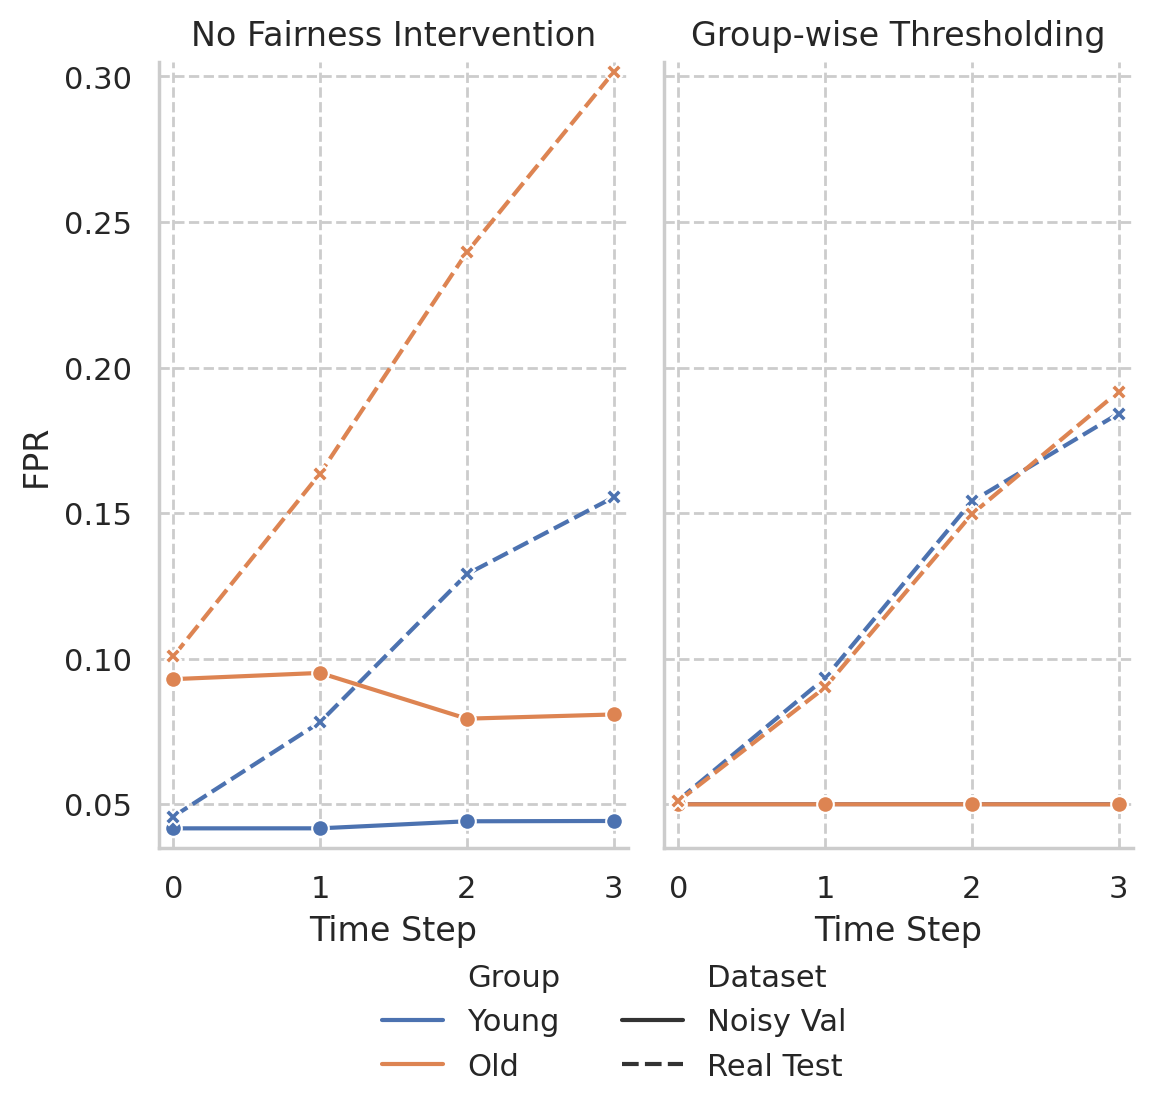

In [11]:
window_rel_plot(
    df=df,
    y="fpr_group",
    hue="Group",
    style="Dataset",
    markers=True,
    xmin=-0.1, xmax=3.1,
    ymin=0.035, ymax=0.305,#0.305,
    xlabel="Window", xticks=range(4),
    ylabel="FPR", yticks=np.arange(0.05, 0.31, 0.05),
    legend=True, bbox_loc="lower center", l_title="", ncol=2,
    bbox_w=0.46, bbox_h=-0.125,
    title=False, column="Drop",
    dashes=True
)